# Table of Contents

1. [Data Import & Manipulation](#1.-Data-Import-&-Manipulation) 
    1. [Fuel Output & Demand Data](#A.-Fuel-Output-&-Demand-Data)
    2. [HOEP Data](#B.-HOEP-Data)
    3. [NG Production & Demand Data](#C.-NG-Production-&-Demand-Data)
    4. [Transportation Demand Data](#D.-Transportation-Demand-Data)
    5. [Industry Demand Data](#E.-Industry-Demand-Data)
    6. [Emission Factor Calculation](#F.-Emission-Factor-Calculation)
    7. [Input-Data-to-MILP](#G.-Input-Data-to-MILP)
2. [Mixed Integer Linear Programming](#2.-Mixed-Integer-Linear-Programming)

# Libraries

In [1]:
import pandas as pd

# Variables 

In [2]:
raw=pd.read_csv('Variables.csv')
raw2=raw.dropna(axis='columns',how='all')
var=raw2.dropna(axis='rows',how='all')
var.set_index("variable_name",inplace=True)

In [3]:
var

,value,unit,source,comment
variable_name,,,,
MW_H2,1.008000e+00,kg/kmol,internet,NaN
density_H2,8.990000e-02,kg/m^3,ushnik,NaN
electrolyzer_eff,7.667000e-01,dimensionless,eqtn 3.1,NaN
E_hhv_h2,3.550000e+00,kWh/m^3 H2,eqtn 3.1,NaN
E_rated_h2,4.630000e+00,kWh/m^3 H2,eqtn 3.1,NaN
min_E_cap,0.000000e+00,kWh,eqtn 3.3,NaN
max_E_cap,1.000000e+03,kWh,eqtn 3.3,NaN
water_cons_rate,4.000000e-01,L H2O/m^3 H2,eqtn 3.4,NaN
meth_reactor_eff,7.700000e-01,dimensionless,eqtn 3.13,NaN


# 1. Data Import & Manipuation

## A. Fuel Output & Demand Data

Fuel output by sources (i.e. nuclear, gas, hydro)

In [4]:
fuel_output = pd.read_csv('on_fuel_source_output_2017.csv', keep_default_na=False, na_values=[""])

Fuel demand in Onatrio 

In [5]:
fuel_demand = pd.read_csv('on_demand_2017.csv', keep_default_na=False, na_values=[""])

In [6]:
fuel_output.head()

,Date,Hour,Fuel,Output
0,2017-01-01,1,NUCLEAR,11592
1,2017-01-01,1,GAS,234
2,2017-01-01,1,HYDRO,2455
3,2017-01-01,1,WIND,2433
4,2017-01-01,1,SOLAR,0


subtract 1 hour because we want 0 to 23 hr 

In [7]:
fuel_output['Hour'] = fuel_output['Hour'] - 1

In [8]:
fuel_output.head()

,Date,Hour,Fuel,Output
0,2017-01-01,0,NUCLEAR,11592
1,2017-01-01,0,GAS,234
2,2017-01-01,0,HYDRO,2455
3,2017-01-01,0,WIND,2433
4,2017-01-01,0,SOLAR,0


In [9]:
fuel_demand.head()

,Date,Hour,Ontario Demand,Northwest,Northeast,Ottawa,East,Toronto,Essa,Bruce,Southwest,Niagara,West,Zone Total,Diff
0,2017-01-01,1,13522,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,268"
1,2017-01-01,2,13117,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,673"
2,2017-01-01,3,12816,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,974"
3,2017-01-01,4,12605,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"3,186"
4,2017-01-01,5,12563,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"3,227"


In [10]:
fuel_demand['Hour'] = fuel_demand['Hour'] -1

In [11]:
fuel_demand.head()

,Date,Hour,Ontario Demand,Northwest,Northeast,Ottawa,East,Toronto,Essa,Bruce,Southwest,Niagara,West,Zone Total,Diff
0,2017-01-01,0,13522,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,268"
1,2017-01-01,1,13117,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,673"
2,2017-01-01,2,12816,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,974"
3,2017-01-01,3,12605,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"3,186"
4,2017-01-01,4,12563,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"3,227"


Create Datetime columns in both df

In [12]:
fuel_output['Datetime'] = pd.to_datetime(fuel_output['Date']) + pd.to_timedelta(fuel_output['Hour'], unit='h')

In [13]:
fuel_output.head()

,Date,Hour,Fuel,Output,Datetime
0,2017-01-01,0,NUCLEAR,11592,2017-01-01
1,2017-01-01,0,GAS,234,2017-01-01
2,2017-01-01,0,HYDRO,2455,2017-01-01
3,2017-01-01,0,WIND,2433,2017-01-01
4,2017-01-01,0,SOLAR,0,2017-01-01


In [14]:
fuel_demand['Datetime'] = pd.to_datetime(fuel_demand['Date']) + pd.to_timedelta(fuel_demand['Hour'], unit='h')

In [15]:
fuel_demand.head()

,Date,Hour,Ontario Demand,Northwest,Northeast,Ottawa,East,Toronto,Essa,Bruce,Southwest,Niagara,West,Zone Total,Diff,Datetime
0,2017-01-01,0,13522,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,268",2017-01-01 00:00:00
1,2017-01-01,1,13117,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,673",2017-01-01 01:00:00
2,2017-01-01,2,12816,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,974",2017-01-01 02:00:00
3,2017-01-01,3,12605,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"3,186",2017-01-01 03:00:00
4,2017-01-01,4,12563,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"3,227",2017-01-01 04:00:00


Groupby Datetime

In [16]:
fuel_output_total = pd.DataFrame(fuel_output.groupby('Datetime')['Output'].sum())
fuel_output_total.columns = ['fuel_total']

In [17]:
fuel_output_total.head()

,fuel_total
Datetime,
2017-01-01 00:00:00,16715
2017-01-01 01:00:00,16344
2017-01-01 02:00:00,15942
2017-01-01 03:00:00,15727
2017-01-01 04:00:00,15653


Set index using Datetime

In [18]:
fuel_demand.set_index('Datetime',inplace=True)

In [19]:
fuel_demand.head()

,Date,Hour,Ontario Demand,Northwest,Northeast,Ottawa,East,Toronto,Essa,Bruce,Southwest,Niagara,West,Zone Total,Diff
Datetime,,,,,,,,,,,,,,,
2017-01-01 00:00:00,2017-01-01,0,13522,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,268"
2017-01-01 01:00:00,2017-01-01,1,13117,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,673"
2017-01-01 02:00:00,2017-01-01,2,12816,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,974"
2017-01-01 03:00:00,2017-01-01,3,12605,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"3,186"
2017-01-01 04:00:00,2017-01-01,4,12563,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"3,227"


Create SBG data by joining the two data and taking the difference

In [20]:
SBG = pd.merge(fuel_output_total[['fuel_total']],fuel_demand[['Ontario Demand']], how='inner',left_index=True, right_index=True)

In [21]:
SBG.head()

,fuel_total,Ontario Demand
Datetime,,
2017-01-01 00:00:00,16715,13522
2017-01-01 01:00:00,16344,13117
2017-01-01 02:00:00,15942,12816
2017-01-01 03:00:00,15727,12605
2017-01-01 04:00:00,15653,12563


In [22]:
SBG['Difference'] = SBG['fuel_total'] - SBG['Ontario Demand']

In [23]:
SBG.head()

,fuel_total,Ontario Demand,Difference
Datetime,,,
2017-01-01 00:00:00,16715,13522,3193
2017-01-01 01:00:00,16344,13117,3227
2017-01-01 02:00:00,15942,12816,3126
2017-01-01 03:00:00,15727,12605,3122
2017-01-01 04:00:00,15653,12563,3090


Check if there's any cell with difference less than 0

In [24]:
SBG[SBG['Difference']<0].count()

fuel_total        697
Ontario Demand    697
Difference        697
dtype: int64

Assign negative numbers with 0's 

In [25]:
SBG.loc[SBG['Difference']<=0,'Difference'] = 0

In [26]:
SBG[SBG['Difference']<0].count()

fuel_total        0
Ontario Demand    0
Difference        0
dtype: int64

Convert SBG MWh to KWh

In [27]:
SBG['Difference'] = SBG['Difference']*1000

Export the SBG data to a csv file

In [28]:
SBG.columns = ['fuel_output','fuel_demand','SBG(kWh)']

In [29]:
SBG.head()

,fuel_output,fuel_demand,SBG(kWh)
Datetime,,,
2017-01-01 00:00:00,16715,13522,3193000
2017-01-01 01:00:00,16344,13117,3227000
2017-01-01 02:00:00,15942,12816,3126000
2017-01-01 03:00:00,15727,12605,3122000
2017-01-01 04:00:00,15653,12563,3090000


## B. HOEP Data

HOEP values are reported as $/Mwh

In [30]:
hoep_data = pd.read_csv('HOEP_2017.csv', keep_default_na=False, na_values=[""])

In [31]:
hoep_data.head()

,Date,Hour,HOEP,Hour 1 Predispatch,Hour 2 Predispatch,Hour 3 Predispatch,OR 10 Min Sync,OR 10 Min non-sync,OR 30 Min
0,2017-01-01,1,0.0,5.94,0.0,0.0,NaN,NaN,NaN
1,2017-01-01,2,0.0,0.00,2.2,0.0,NaN,NaN,NaN
2,2017-01-01,3,0.0,0.00,0.0,0.0,NaN,NaN,NaN
3,2017-01-01,4,0.0,0.00,0.0,0.0,NaN,NaN,NaN
4,2017-01-01,5,0.0,0.00,0.0,0.0,NaN,NaN,NaN


In [32]:
hoep_data['Hour'] = hoep_data['Hour'] -1

In [33]:
hoep_data['Datetime'] = pd.to_datetime(hoep_data['Date']) + pd.to_timedelta(hoep_data['Hour'], unit='h')

In [34]:
hoep_data.head()

,Date,Hour,HOEP,Hour 1 Predispatch,Hour 2 Predispatch,Hour 3 Predispatch,OR 10 Min Sync,OR 10 Min non-sync,OR 30 Min,Datetime
0,2017-01-01,0,0.0,5.94,0.0,0.0,NaN,NaN,NaN,2017-01-01 00:00:00
1,2017-01-01,1,0.0,0.00,2.2,0.0,NaN,NaN,NaN,2017-01-01 01:00:00
2,2017-01-01,2,0.0,0.00,0.0,0.0,NaN,NaN,NaN,2017-01-01 02:00:00
3,2017-01-01,3,0.0,0.00,0.0,0.0,NaN,NaN,NaN,2017-01-01 03:00:00
4,2017-01-01,4,0.0,0.00,0.0,0.0,NaN,NaN,NaN,2017-01-01 04:00:00


In [35]:
hoep_data.set_index('Datetime',inplace=True)

In [36]:
hoep_data.head(10)

,Date,Hour,HOEP,Hour 1 Predispatch,Hour 2 Predispatch,Hour 3 Predispatch,OR 10 Min Sync,OR 10 Min non-sync,OR 30 Min
Datetime,,,,,,,,,
2017-01-01 00:00:00,2017-01-01,0,0.00,5.94,0.00,0.00,NaN,NaN,NaN
2017-01-01 01:00:00,2017-01-01,1,0.00,0.00,2.20,0.00,NaN,NaN,NaN
2017-01-01 02:00:00,2017-01-01,2,0.00,0.00,0.00,0.00,NaN,NaN,NaN
2017-01-01 03:00:00,2017-01-01,3,0.00,0.00,0.00,0.00,NaN,NaN,NaN
2017-01-01 04:00:00,2017-01-01,4,0.00,0.00,0.00,0.00,NaN,NaN,NaN
2017-01-01 05:00:00,2017-01-01,5,0.00,0.01,0.00,1.99,NaN,NaN,NaN
2017-01-01 06:00:00,2017-01-01,6,0.00,5.94,6.04,6.02,NaN,NaN,NaN
2017-01-01 07:00:00,2017-01-01,7,1.71,6.74,8.42,6.74,NaN,NaN,NaN
2017-01-01 08:00:00,2017-01-01,8,0.00,5.74,5.70,5.84,NaN,NaN,NaN


HOEP data is dollar/Mwh so need to convert to dollar/kWh

In [37]:
hoep_data['HOEP']= hoep_data['HOEP']/1000

In [38]:
input_df = pd.merge(SBG[['SBG(kWh)']],hoep_data[['HOEP']], how='inner',left_index=True, right_index=True)

In [39]:
input_df.head(10)

,SBG(kWh),HOEP
Datetime,,
2017-01-01 00:00:00,3193000,0.00000
2017-01-01 01:00:00,3227000,0.00000
2017-01-01 02:00:00,3126000,0.00000
2017-01-01 03:00:00,3122000,0.00000
2017-01-01 04:00:00,3090000,0.00000
2017-01-01 05:00:00,2898000,0.00000
2017-01-01 06:00:00,2739000,0.00000
2017-01-01 07:00:00,2726000,0.00171
2017-01-01 08:00:00,2267000,0.00000


## C. NG Production & Demand Data

In [40]:
NG_hourly_distribution = pd.read_csv('NG_hourly_distribution.csv')

In [41]:
NG_hourly_distribution.head()

,hour,hourly_distribution
0,1,105
1,2,100
2,3,95
3,4,95
4,5,100


In [42]:
NG_hourly_distribution['ratio'] = NG_hourly_distribution['hourly_distribution']/sum(NG_hourly_distribution['hourly_distribution'])

In [43]:
NG_hourly_distribution['hour'] = NG_hourly_distribution['hour']-1

In [44]:
NG_hourly_distribution.head()

,hour,hourly_distribution,ratio
0,0,105,0.033113
1,1,100,0.031536
2,2,95,0.029959
3,3,95,0.029959
4,4,100,0.031536


In [45]:
NG_monthly_production = pd.read_csv('NG_monthly_production.csv')

In [46]:
NG_monthly_production.head()

,month,NG_production(e3m3/d)
0,1,6184
1,2,6165
2,3,6168
3,4,5978
4,5,6170


In [47]:
input_df['NG_demand(m^3)'] = 0
input_df['NG_demand(m^3)'] = input_df['NG_demand(m^3)'].astype(float)
input_df.head()

,SBG(kWh),HOEP,NG_demand(m^3)
Datetime,,,
2017-01-01 00:00:00,3193000,0.0,0.0
2017-01-01 01:00:00,3227000,0.0,0.0
2017-01-01 02:00:00,3126000,0.0,0.0
2017-01-01 03:00:00,3122000,0.0,0.0
2017-01-01 04:00:00,3090000,0.0,0.0


NG demand calculation

In [48]:
for index, row in input_df.iterrows():
   
    curr_hour = index.hour
    curr_month = index.month 
    ratio = NG_hourly_distribution[NG_hourly_distribution['hour']==curr_hour]['ratio'].iloc[0]
    NG_prod = NG_monthly_production[NG_monthly_production['month']==curr_month]['NG_production(e3m3/d)'].iloc[0]
  
    input_df.loc[index,'NG_demand(m^3)'] = (ratio * NG_prod).round(3)*1000
    

In [49]:
input_df.head()

,SBG(kWh),HOEP,NG_demand(m^3)
Datetime,,,
2017-01-01 00:00:00,3193000,0.0,204768.0
2017-01-01 01:00:00,3227000,0.0,195017.0
2017-01-01 02:00:00,3126000,0.0,185266.0
2017-01-01 03:00:00,3122000,0.0,185266.0
2017-01-01 04:00:00,3090000,0.0,195017.0


## D. Transportation Demand Data

In [50]:
mobility_hourly_distribution = pd.read_csv('mobility_hourly_distribution.csv')

In [51]:
mobility_hourly_distribution.head()

,hour,% of daily demand
0,1,1.05
1,2,0.80
2,3,0.70
3,4,0.40
4,5,0.90


In [52]:
mobility_hourly_distribution['hour'] = mobility_hourly_distribution['hour'] -1

In [53]:
mobility_hourly_distribution.head()

,hour,% of daily demand
0,0,1.05
1,1,0.80
2,2,0.70
3,3,0.40
4,4,0.90


264000 kg demand * 1m^3/0.0899kg H2 

In [54]:
mobility_hourly_distribution['demand(m^3)'] = mobility_hourly_distribution['% of daily demand'] / 100 * 264000 /0.0899

In [55]:
mobility_hourly_distribution.head()

,hour,% of daily demand,demand(m^3)
0,0,1.05,30834.260289
1,1,0.80,23492.769744
2,2,0.70,20556.173526
3,3,0.40,11746.384872
4,4,0.90,26429.365962


Weekly profile according to Azadeh's workbook

In [56]:
# weekday number 6= Sunday, 0 = Monday,... 5 = Saturday 
week_profile_dict = {'weekday': [6,0,1,2,3,4,5],
         'factor': [101,94,96,100,105,108,96]}
week_profile_df = pd.DataFrame.from_dict(week_profile_dict)
week_profile_df['factor_fraction'] = week_profile_df['factor']/100
week_profile_df

,factor,weekday,factor_fraction
0,101,6,1.01
1,94,0,0.94
2,96,1,0.96
3,100,2,1.00
4,105,3,1.05
5,108,4,1.08
6,96,5,0.96


In [57]:
input_df['mobility_demand(m^3)'] = 0
input_df['mobility_demand(m^3)'] = input_df['mobility_demand(m^3)'].astype(float)
input_df.head()

,SBG(kWh),HOEP,NG_demand(m^3),mobility_demand(m^3)
Datetime,,,,
2017-01-01 00:00:00,3193000,0.0,204768.0,0.0
2017-01-01 01:00:00,3227000,0.0,195017.0,0.0
2017-01-01 02:00:00,3126000,0.0,185266.0,0.0
2017-01-01 03:00:00,3122000,0.0,185266.0,0.0
2017-01-01 04:00:00,3090000,0.0,195017.0,0.0


In [58]:
for index, row in input_df.iterrows():
    curr_weekday = index.weekday()
    curr_hour = index.hour 
    week_factor = week_profile_df[week_profile_df['weekday']==curr_weekday]['factor_fraction'].iloc[0]
    mob_demand = mobility_hourly_distribution[mobility_hourly_distribution['hour']==curr_hour]['demand(m^3)'].iloc[0]
    input_df.loc[index,'mobility_demand(m^3)'] = mob_demand * week_factor 

In [59]:
input_df.head()

,SBG(kWh),HOEP,NG_demand(m^3),mobility_demand(m^3)
Datetime,,,,
2017-01-01 00:00:00,3193000,0.0,204768.0,31142.602892
2017-01-01 01:00:00,3227000,0.0,195017.0,23727.697442
2017-01-01 02:00:00,3126000,0.0,185266.0,20761.735261
2017-01-01 03:00:00,3122000,0.0,185266.0,11863.848721
2017-01-01 04:00:00,3090000,0.0,195017.0,26693.659622


## E. Industry Demand Data

Total industry production capacity (MSm^3/day)

In [60]:
total_daily_production = 6.3 #MSm^3/day

In [61]:
total_yearly_production = total_daily_production * 365

print(total_yearly_production)

2299.5


Industry demand monthly according to the paper 

In [62]:
ind_demand_dic = {'month': [1,2,3,4,5,6,7,8,9,10,11,12],
         'monthly_demand_hydrogen[kg]': [3.2,2.7,2.4,2.1,2,1.8,1.7,2,2.1,2.7,3,3.3]
         }
monthly_hydrogen_demand = pd.DataFrame.from_dict(ind_demand_dic)
total_hydrogen_demand = monthly_hydrogen_demand['monthly_demand_hydrogen[kg]'].sum()
monthly_hydrogen_demand['percentage'] = monthly_hydrogen_demand['monthly_demand_hydrogen[kg]']/total_hydrogen_demand
monthly_hydrogen_demand['production_capacity[m^3/day]'] = total_yearly_production * monthly_hydrogen_demand['percentage'] * (10**6)
monthly_hydrogen_demand

,month,monthly_demand_hydrogen[kg],percentage,production_capacity[m^3/day]
0,1,3.2,0.110345,2.537379e+08
1,2,2.7,0.093103,2.140914e+08
2,3,2.4,0.082759,1.903034e+08
3,4,2.1,0.072414,1.665155e+08
4,5,2.0,0.068966,1.585862e+08
5,6,1.8,0.062069,1.427276e+08
6,7,1.7,0.058621,1.347983e+08
7,8,2.0,0.068966,1.585862e+08
8,9,2.1,0.072414,1.665155e+08
9,10,2.7,0.093103,2.140914e+08


Creating '0' cells for hourly industry demands

In [63]:
input_df['industry_demand(m^3)'] = 0
input_df['industry_demand(m^3)'] = input_df['industry_demand(m^3)'].astype(float)
input_df.head()

,SBG(kWh),HOEP,NG_demand(m^3),mobility_demand(m^3),industry_demand(m^3)
Datetime,,,,,
2017-01-01 00:00:00,3193000,0.0,204768.0,31142.602892,0.0
2017-01-01 01:00:00,3227000,0.0,195017.0,23727.697442,0.0
2017-01-01 02:00:00,3126000,0.0,185266.0,20761.735261,0.0
2017-01-01 03:00:00,3122000,0.0,185266.0,11863.848721,0.0
2017-01-01 04:00:00,3090000,0.0,195017.0,26693.659622,0.0


number of days in each month

In [64]:
num_days_dic = {'month': [1,2,3,4,5,6,7,8,9,10,11,12],
         'number_of_days': [31,28,31,30,31,30,31,31,30,31,30,31]}
num_days_df = pd.DataFrame.from_dict(num_days_dic)
num_days_df

,month,number_of_days
0,1,31
1,2,28
2,3,31
3,4,30
4,5,31
5,6,30
6,7,31
7,8,31
8,9,30
9,10,31


Create hourly profile for industry demand 

In [65]:
for index, row in input_df.iterrows():
    curr_month = index.month 
    num_days = num_days_df[num_days_df['month']==curr_month]['number_of_days'].iloc[0]
    ind_prod = monthly_hydrogen_demand[monthly_hydrogen_demand['month']==curr_month]['production_capacity[m^3/day]'].iloc[0]
    input_df.loc[index,'industry_demand(m^3)'] = ind_prod / (num_days * 24) * 0.05

In [66]:
input_df.head()

,SBG(kWh),HOEP,NG_demand(m^3),mobility_demand(m^3),industry_demand(m^3)
Datetime,,,,,
2017-01-01 00:00:00,3193000,0.0,204768.0,31142.602892,17052.280311
2017-01-01 01:00:00,3227000,0.0,195017.0,23727.697442,17052.280311
2017-01-01 02:00:00,3126000,0.0,185266.0,20761.735261,17052.280311
2017-01-01 03:00:00,3122000,0.0,185266.0,11863.848721,17052.280311
2017-01-01 04:00:00,3090000,0.0,195017.0,26693.659622,17052.280311


## F. Emission Factor Calculation

In [67]:
#EMF(tonne/kWh)

emission_factor = fuel_output.copy()
emission_factor['Emission'] = 0
emission_factor['Emission'] = emission_factor['Emission'].astype(float)
emission_factor.head()


#all in kgCO2/MWh 
EMF_nuclear = 17 
EMF_gas = 622
EMF_hydro = 18
EMF_wind = 14
EMF_solar = 39
EMF_biofuel = 177


for index, row in emission_factor.iterrows():
    fuel_type = row['Fuel']
    
    if fuel_type == 'NUCLEAR':
        EMF = EMF_nuclear
    elif fuel_type == 'GAS':
        EMF = EMF_gas
    elif fuel_type == 'HYDRO':
        EMF = EMF_hydro
    elif fuel_type == 'BIOFUEL':
        EMF = EMF_biofuel
    elif fuel_type == 'SOLAR':
        EMF = EMF_solar
    else:
        EMF = EMF_wind
        
    emission_factor.loc[index,'Emission'] = EMF * emission_factor.loc[index,'Output']

emission_factor.head()

emission_factor_agg = pd.DataFrame(emission_factor.groupby('Datetime').agg({'Emission':'sum','Output':'sum'}))

emission_factor_agg['EMF(kgCO2/MWh)'] = emission_factor_agg['Emission'] / emission_factor_agg['Output'] 
emission_factor_agg['EMF(tonne/kWh)'] = emission_factor_agg['EMF(kgCO2/MWh)'] / 1000 / 1000 #unit conversion 1tonne/1000kg, 1MW/1000kW
emission_factor_agg.head()

,Emission,Output,EMF(kgCO2/MWh),EMF(tonne/kWh)
Datetime,,,,
2017-01-01 00:00:00,421041.0,16715,25.189411,0.000025
2017-01-01 01:00:00,416724.0,16344,25.497063,0.000025
2017-01-01 02:00:00,410267.0,15942,25.734977,0.000026
2017-01-01 03:00:00,408635.0,15727,25.983023,0.000026
2017-01-01 04:00:00,406922.0,15653,25.996422,0.000026


In [68]:
input_df = pd.merge(input_df,emission_factor_agg[['EMF(tonne/kWh)']], how='inner',left_index=True, right_index=True)
input_df.head()

,SBG(kWh),HOEP,NG_demand(m^3),mobility_demand(m^3),industry_demand(m^3),EMF(tonne/kWh)
Datetime,,,,,,
2017-01-01 00:00:00,3193000,0.0,204768.0,31142.602892,17052.280311,0.000025
2017-01-01 01:00:00,3227000,0.0,195017.0,23727.697442,17052.280311,0.000025
2017-01-01 02:00:00,3126000,0.0,185266.0,20761.735261,17052.280311,0.000026
2017-01-01 03:00:00,3122000,0.0,185266.0,11863.848721,17052.280311,0.000026
2017-01-01 04:00:00,3090000,0.0,195017.0,26693.659622,17052.280311,0.000026


## G. Input Data to MILP

In [69]:
input_df.head(10)

,SBG(kWh),HOEP,NG_demand(m^3),mobility_demand(m^3),industry_demand(m^3),EMF(tonne/kWh)
Datetime,,,,,,
2017-01-01 00:00:00,3193000,0.00000,204768.0,31142.602892,17052.280311,0.000025
2017-01-01 01:00:00,3227000,0.00000,195017.0,23727.697442,17052.280311,0.000025
2017-01-01 02:00:00,3126000,0.00000,185266.0,20761.735261,17052.280311,0.000026
2017-01-01 03:00:00,3122000,0.00000,185266.0,11863.848721,17052.280311,0.000026
2017-01-01 04:00:00,3090000,0.00000,195017.0,26693.659622,17052.280311,0.000026
2017-01-01 05:00:00,2898000,0.00000,214519.0,32625.583982,17052.280311,0.000026
2017-01-01 06:00:00,2739000,0.00000,273024.0,60802.224694,17052.280311,0.000026
2017-01-01 07:00:00,2726000,0.00171,282775.0,90461.846496,17052.280311,0.000026
2017-01-01 08:00:00,2267000,0.00000,243772.0,120121.468298,17052.280311,0.000026


In [70]:
input_df.reset_index(inplace=True)
input_df.head(10)

,Datetime,SBG(kWh),HOEP,NG_demand(m^3),mobility_demand(m^3),industry_demand(m^3),EMF(tonne/kWh)
0,2017-01-01 00:00:00,3193000,0.00000,204768.0,31142.602892,17052.280311,0.000025
1,2017-01-01 01:00:00,3227000,0.00000,195017.0,23727.697442,17052.280311,0.000025
2,2017-01-01 02:00:00,3126000,0.00000,185266.0,20761.735261,17052.280311,0.000026
3,2017-01-01 03:00:00,3122000,0.00000,185266.0,11863.848721,17052.280311,0.000026
4,2017-01-01 04:00:00,3090000,0.00000,195017.0,26693.659622,17052.280311,0.000026
5,2017-01-01 05:00:00,2898000,0.00000,214519.0,32625.583982,17052.280311,0.000026
6,2017-01-01 06:00:00,2739000,0.00000,273024.0,60802.224694,17052.280311,0.000026
7,2017-01-01 07:00:00,2726000,0.00171,282775.0,90461.846496,17052.280311,0.000026
8,2017-01-01 08:00:00,2267000,0.00000,243772.0,120121.468298,17052.280311,0.000026
9,2017-01-01 09:00:00,2324000,0.00000,234021.0,166093.882091,17052.280311,0.000026


# 2. Mixed Integer Linear Programming

Numbering variables 
<br>
1. RNG <br>
2. HENG <br>
3. Transportation <br>
4. Industry

In [78]:
"""
Model for Transportation
"""

import pulp
import pandas as pd

# Time-series constants
SBG = list(input_df['SBG(kWh)']) #kwh
mobility_demand = list(input_df['mobility_demand(m^3)']) #m^3
HOEP = list(input_df['HOEP']) #$/kwh
EMF = list(input_df['EMF(tonne/kWh)'])

# Fixed constants for other models 
nu_electrolyzer = var['value']['electrolyzer_eff'] #dimensionless
E_HHV_H2 = var['value']['E_hhv_h2'] #kwh/m^3
nu_reactor = var['value']['meth_reactor_eff'] #dimensionless
HHV_H2 = var['value']['HHV_H2'] #MMBtu/kmol
HHV_NG = var['value']['HHV_NG'] #MMBtu/kmol 
# CO2_available = var['value']['CO2_available'] #m^3/h
E_electrolyzer_min = var['value']['min_E_cap'] #kwh
E_electrolyzer_max = var['value']['max_E_cap'] #kwh
tau = 0.50

EMF_NG = var['value']['EMF_NG'] #tonne CO2/m^3 H2
EMF_comb = var['value']['EMF_combRNG'] #tonne CO2 /m^3 H2
EMF_nuc = var['value']['EMF_nuclear'] #tonne CO2 / kWh
EMF_bio = var['value']['EMF_bioCO2'] #tonne CO2/m^3 bio CO2
EMF_electrolyzer = var['value']['EMF_electrolyzer'] #tonne CO2 /m^3 H2
EMF_reactor = var['value']['EMF_reactor'] #tonne CO2 /m^3 RNG produced
EMF_vehicle = var['value']['emission_gasoline_v'] #tonne CO2/car/year
num_vehicle = var['value']['N_gasoline_v']
FCV_penetration = var['value']['FCV_penetration'] #FCV market penetration (estimated)


beta = var['value']['beta']
C_0 = var['value']['C_0'] #$/kW
mu = var['value']['mu']
gamma = var['value']['gamma']
k = var['value']['k'] #$
C_upgrading = var['value']['C_upgrading'] #$/m^3 reactor capacity 
C_CO2 = var['value']['C_CO2']#$/m^3 CO2
TC = var['value']['TC'] #$/kWh
C_H2O = var['value']['C_H2O'] #$/L 
WCR = var['value']['water_cons_rate'] #L H2o/m^3 H2
OPEX_upgrading = var['value']['OPEX_upgrading'] #$/m^3 reactor capacity 
TVM = var['value']['TVM']



# Fixed constants for transportation models 
Imax = var['value']['Imax'] #kmol
Imin= var['value']['Imin'] #kmol
Fmax_booster = var['value']['Fmax_booster'] #kmol
Fmax_prestorage =var['value']['Fmax_prestorage'] #kmol

CAPEX_booster = var['value']['CAPEX_booster'] #$
CAPEX_prestorage = var['value']['CAPEX_prestorage'] #$
CAPEX_tank = var['value']['CAPEX_tank'] #$

ECF_prestorage = var['value']['ECF_prestorage'] #kWh/kmol H2 

z_booster = var['value']['z_booster'] #compressibility factor for booster compressor 
R = var['value']['R'] #kJ/kmolK
T = var['value']['T'] #K
comp_efficiency = var['value']['comp_efficiency']  #isentropic compressor efficiency 
heat_cap_ratio = var['value']['heat_cap_ratio'] #heat capacaity ratio of hydrogen 
P_in_booster = var['value']['P_in_booster'] #inlet pressure of booster compressor
P_out_booster = var['value']['P_out_booster'] #outlet pressure of booster compressor 
N_stage_booster = var['value']['N_stage_booster']

ECF_booster = z_booster * R * T * N_stage_booster / comp_efficiency * \
                heat_cap_ratio / (heat_cap_ratio - 1) * \
                (((P_out_booster / P_in_booster) ** ((heat_cap_ratio - 1) / N_stage_booster / heat_cap_ratio ))-1) \
                / 3600 #converting kJ to kWh ECF booster in kWh/kmol
            
#converting the transportation constants to m^3 
MW_H2 = var['value']['MW_H2'] #kg/kmol H2
density_H2 = var['value']['density_H2'] #kg/m^3

Imax = Imax * MW_H2 / density_H2 # m^3
Imin = Imin * MW_H2 / density_H2 # m^3
Fmax_booster = Fmax_booster * MW_H2 / density_H2 # m^3
Fmax_prestorage = Fmax_prestorage * MW_H2 / density_H2 # m^3


ECF_booster = ECF_booster / MW_H2 * density_H2 #kWh/m^3
ECF_prestorage = ECF_prestorage / MW_H2 * density_H2 #kWh/m^3


#number of electrolyzer max
N_electrolyzer_max = int(10000)



# Transportation model
LP_3 = pulp.LpProblem('LP', pulp.LpMinimize)


N_electrolyzer_3 = pulp.LpVariable('N_electrolyzer_3',
                          lowBound=0,
                          cat='Integer')

N_booster = pulp.LpVariable('N_booster',
                          lowBound=0,
                          cat='Integer')

N_prestorage = pulp.LpVariable('N_prestorage',
                          lowBound=0,
                          cat='Integer')

N_tank = pulp.LpVariable('N_tank',
                          lowBound=0,
                          cat='Integer')


alpha_3 = pulp.LpVariable.dicts('alpha_3',
                          [str(i) for i in range(1, N_electrolyzer_max+1)],
                          cat='Binary')


E_3 = pulp.LpVariable.dicts('E_3',
                          [str(i) for i in input_df.index],
                          lowBound=0,
                          cat='Continuous')

H2_3 = pulp.LpVariable.dicts('H2_3',
                          [str(i) for i in input_df.index],
                          lowBound=0,
                          cat='Continuous')

#hydrogen delivered directly to the booster compressor 
H2_direct = pulp.LpVariable.dicts('H2_direct',
                          [str(i) for i in input_df.index],
                          lowBound=0,
                          cat='Continuous')

#hydrogen going into the tank 
H2_tank_in = pulp.LpVariable.dicts('H2_tank_in',
                          [str(i) for i in input_df.index],
                          lowBound=0,
                          cat='Continuous')
#hydrogen leaving the tank
H2_tank_out = pulp.LpVariable.dicts('H2_tank_out',
                          [str(i) for i in input_df.index],
                          lowBound=0,
                          cat='Continuous')

#hydrogen inventory in the tank
I_H2 = pulp.LpVariable.dicts('I_H2',
                          [str(i) for i in input_df.index],
                          lowBound=0,
                          cat='Continuous')

em_compressor = pulp.LpVariable('em_compressor',
                          lowBound=0,
                          cat='Continuous')


CAPEX_3 = pulp.LpVariable('CAPEX_3', lowBound=0, cat='Continuous')
OPEX_3 = pulp.LpVariable('OPEX_3', lowBound=0, cat='Continuous')

for i, h in enumerate([str(i) for i in input_df.index]):
    
    # Energy and flow constraints
    LP_3 += H2_3[h] == nu_electrolyzer * E_3[h] / E_HHV_H2
    LP_3 += H2_3[h] == H2_tank_in[h] + H2_direct[h] 

    #hydrogen storage inventory constraint 
    if h == '0': #at hour zero, accumulation assumed to be Imin*Ntank
        LP_3 += I_H2[h] == Imin * N_tank + H2_tank_in[h] - H2_tank_out[h]
    else: #at hour non zero accumulation exists 
        LP_3 += I_H2[h] == I_H2[str(i-1)] + H2_tank_in[h] - H2_tank_out[h]
    

    # Demand constraint
    LP_3 += H2_tank_out[h] + H2_direct[h] == mobility_demand[i] 

    # Electrolyzer constraints 
    LP_3 += N_electrolyzer_3 * E_electrolyzer_min <= E_3[h]
    LP_3 += N_electrolyzer_3 * E_electrolyzer_max >= E_3[h]
    LP_3 += E_3[h] <= SBG[i]
    
    
    if h == '0':
        #Number of eletrolyzer constraint 
        LP_3 += pulp.lpSum(n * alpha_3[str(n)] for n in range(1, N_electrolyzer_max+1)) == N_electrolyzer_3
        LP_3 += pulp.lpSum(alpha_3) <= 1
         
    #storage inventory constraint 
    LP_3 += I_H2[h] <= Imax * N_tank  
    LP_3 += I_H2[h] >= Imin * N_tank

    #compressor capacity constraint
    LP_3 += H2_tank_in[h] <= N_prestorage * Fmax_prestorage
    LP_3 += H2_tank_out[h] + H2_direct[h] <= N_booster * Fmax_booster

    
# Cost of electrolyzer list
C_electrolyzer = [beta * C_0 * i ** mu for i in range(1, N_electrolyzer_max+1)]

# CAPEX
LP_3 += pulp.lpSum(alpha_3[str(n)] * C_electrolyzer[n - 1] for n in range(1, N_electrolyzer_max+1)) + \
        (N_booster * CAPEX_booster + \
        N_prestorage * CAPEX_prestorage + \
        N_tank * CAPEX_tank) * TVM == CAPEX_3


LP_3 += pulp.lpSum((E_3[str(n)] + \
                    ECF_booster * (H2_tank_out[str(n)] + H2_direct[str(n)]) + \
                    ECF_prestorage * H2_tank_in[str(n)]) * (HOEP[n] + TC) for n in input_df.index) + \
        pulp.lpSum(H2_3[str(n)] * C_H2O * WCR for n in input_df.index) == OPEX_3


em_offset_fcv = num_vehicle * FCV_penetration * EMF_vehicle

LP_3 += pulp.lpSum(EMF[n] * (ECF_booster * (H2_tank_out[str(n)] + H2_direct[str(n)]) + \
                    ECF_prestorage * H2_tank_in[str(n)]) for n in input_df.index)  == em_compressor


# Objective
LP_3 += CAPEX_3 + OPEX_3 * TVM, 'Cost_3'

LP_3.solve()
print([x.varValue for x in LP_3.variables()])
print(pulp.value(LP_3.objective))
print(LP_3.status)
print(N_electrolyzer_3.value())
print(N_booster.value())
print(N_prestorage.value())
print(N_tank.value())
print(CAPEX_3.value(), OPEX_3.value())


[18612027000.0, 1731590.3, 1697257.6, 2389000.0, 1715885.6, 0.0, 0.0, 0.0, 0.0, 0.0, 141000.0, 0.0, 0.0, 785000.0, 0.0, 1744439.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1253000.0, 0.0, 1110000.0, 1275000.0, 1072554.9, 1083541.4, 0.0, 0.0, 0.0, 0.0, 1419000.0, 1181000.0, 1958186.4, 1845575.0, 1721596.4, 1689643.2, 1676861.9, 1638518.0, 1702424.5, 1727987.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 263000.0, 137059.03, 0.0, 0.0, 0.0, 0.0, 0.0, 1312000.0, 779000.0, 398123.85, 722000.0, 0.0, 1068000.0, 1434000.0, 1476000.0, 1553000.0, 0.0, 1309000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1532000.0, 1332000.0, 706000.0, 455000.0, 0.0, 761439.06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2420991.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1043000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [79]:
print(LP_3.status)
print(N_electrolyzer_3.value())
print(N_booster.value())
print(N_prestorage.value())
print(N_tank.value())
print(CAPEX_3.value(), OPEX_3.value())

1
2611.0
514.0
1456.0
60464.0
18612027000.0 56334636.0


Create variable dictionary using the LP output (i.e. LP_3)

In [80]:
def create_var_dict(LP_object):
    variable_dict = {}
    for v in LP_object.variables():
        variable_dict[v.name] = v.varValue
    
    return variable_dict 

In [81]:
variable_dict = create_var_dict(LP_3)

In [85]:
import numpy as np

#Exporting the variable dictionary as .npy file 
np.save('transportation_result_dict.npy', variable_dict) 

transportation_result_dict = np.load('transportation_result_dict.npy').item()
print(transportation_result_dict)

{'CAPEX_3': 18612027000.0, 'E_3_0': 1731590.3, 'E_3_1': 1697257.6, 'E_3_10': 2389000.0, 'E_3_100': 1715885.6, 'E_3_1000': 0.0, 'E_3_1001': 0.0, 'E_3_1002': 0.0, 'E_3_1003': 0.0, 'E_3_1004': 0.0, 'E_3_1005': 141000.0, 'E_3_1006': 0.0, 'E_3_1007': 0.0, 'E_3_1008': 785000.0, 'E_3_1009': 0.0, 'E_3_101': 1744439.6, 'E_3_1010': 0.0, 'E_3_1011': 0.0, 'E_3_1012': 0.0, 'E_3_1013': 0.0, 'E_3_1014': 0.0, 'E_3_1015': 0.0, 'E_3_1016': 0.0, 'E_3_1017': 0.0, 'E_3_1018': 0.0, 'E_3_1019': 0.0, 'E_3_102': 1253000.0, 'E_3_1020': 0.0, 'E_3_1021': 1110000.0, 'E_3_1022': 1275000.0, 'E_3_1023': 1072554.9, 'E_3_1024': 1083541.4, 'E_3_1025': 0.0, 'E_3_1026': 0.0, 'E_3_1027': 0.0, 'E_3_1028': 0.0, 'E_3_1029': 1419000.0, 'E_3_103': 1181000.0, 'E_3_1030': 1958186.4, 'E_3_1031': 1845575.0, 'E_3_1032': 1721596.4, 'E_3_1033': 1689643.2, 'E_3_1034': 1676861.9, 'E_3_1035': 1638518.0, 'E_3_1036': 1702424.5, 'E_3_1037': 1727987.1, 'E_3_1038': 0.0, 'E_3_1039': 0.0, 'E_3_104': 0.0, 'E_3_1040': 0.0, 'E_3_1041': 0.0, 'E_3_1

Create a dataframe using the variable dictionary above 

In [86]:
def create_var_df(variable_dict,col_string,exc_string=None):
    '''
    variable_dict = dictionary of the variable names and values
    col_string = the variable name of interest including _ at the end (i.e. 'CO2_h_')
    exc_string = the variable you do not want to include (just in case of RNG and RNG_max)
    '''
   
    if exc_string is not None:
        #list of variable values
        var_value = [ v for k,v in variable_dict.items() if  (k.startswith(col_string) and exc_string not in k)]
        #list of variable names 
        var_name = [ k for k,v in variable_dict.items() if (k.startswith(col_string) and exc_string not in k)]
    else:
        #list of variable values
        var_value = [ v for k,v in variable_dict.items() if  k.startswith(col_string) ]
        #list of variable names 
        var_name = [ k for k,v in variable_dict.items() if k.startswith(col_string)]

    print('The length of the list: ',len(var_value))
    #create a df of variable value and name 
    variable_df = []
    
    variable_df = pd.DataFrame(
        {'value': var_value,
         'name': var_name})

    #split the name and create an hour 
    variable_df['hour'] = variable_df['name'].apply(lambda x: x.split(col_string)[1])
    
    #convert the data type to integer 
    variable_df['hour'] = variable_df['hour'].astype(int)
    
    #sort the df by hour 
    variable_df.sort_values(by=['hour'],inplace=True)
    
    print("The first 5 hours of the data:")
    display(variable_df.head())
    
    return variable_df 


In [87]:
H2_3_df = create_var_df(variable_dict,'H2_3_')

The length of the list:  8760
The first 5 hours of the data:


,name,value,hour
0,H2_3_0,373974.73,0
1,H2_3_1,366559.82,1
1112,H2_3_2,363593.86,2
2223,H2_3_3,354695.97,3
3334,H2_3_4,369525.78,4


In [88]:
I_H2_df = create_var_df(variable_dict,'I_H2_')

The length of the list:  8760
The first 5 hours of the data:


,name,value,hour
0,I_H2_0,6116284.7,0
1,I_H2_1,6459116.8,1
1112,I_H2_2,6801949.0,2
2223,I_H2_3,7144781.1,3
3334,I_H2_4,7487613.2,4


In [89]:
H2_tank_in_df = create_var_df(variable_dict,'H2_tank_in_')

The length of the list:  8760
The first 5 hours of the data:


,name,value,hour
0,H2_tank_in_0,342832.12,0
1,H2_tank_in_1,342832.12,1
1112,H2_tank_in_2,342832.12,2
2223,H2_tank_in_3,342832.12,3
3334,H2_tank_in_4,342832.12,4


In [90]:
H2_tank_out_df = create_var_df(variable_dict,'H2_tank_out_')

The length of the list:  8760
The first 5 hours of the data:


,name,value,hour
0,H2_tank_out_0,0.0,0
1,H2_tank_out_1,0.0,1
1112,H2_tank_out_2,0.0,2
2223,H2_tank_out_3,0.0,3
3334,H2_tank_out_4,0.0,4


In [91]:
H2_direct_df = create_var_df(variable_dict,'H2_direct_')

The length of the list:  8760
The first 5 hours of the data:


,name,value,hour
0,H2_direct_0,31142.603,0
1,H2_direct_1,23727.697,1
1112,H2_direct_2,20761.735,2
2223,H2_direct_3,11863.849,3
3334,H2_direct_4,26693.660,4


In [92]:
H2_df = create_var_df(variable_dict,'H2_3_')

The length of the list:  8760
The first 5 hours of the data:


,name,value,hour
0,H2_3_0,373974.73,0
1,H2_3_1,366559.82,1
1112,H2_3_2,363593.86,2
2223,H2_3_3,354695.97,3
3334,H2_3_4,369525.78,4


Functions for creating plots 

In [93]:
def create_plot(df):
    %matplotlib inline
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(20,10))
    plt.plot(df['hour'],df['value'])
    
    
def create_plot_list(mylist):
    %matplotlib inline
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(20,10))
    plt.plot(range(1,len(mylist)+1),mylist)
    
def create_plot_two_lines(df1,df2):
    %matplotlib inline
    import matplotlib.pyplot as plt
    
    fig = plt.figure(figsize = [20,8])
    ax = fig.add_subplot(111)

    lns1 = ax.plot(df1['hour'], df1['value'], '-')

    ax2 = ax.twinx()
    lns2 = ax2.plot(df2['hour'],df2['value'], 'gray')
    
    lns = lns1+lns2 
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=0)

    ax.grid()
    ax.set_xlabel("Hour")
    ax.set_ylabel('df1')
    ax.tick_params(labelrotation=70)
    ax2.set_ylabel('df2')

    
#     plt.savefig(col_list[0]+'_vs_'+col_list[1]+'.png')

   

    

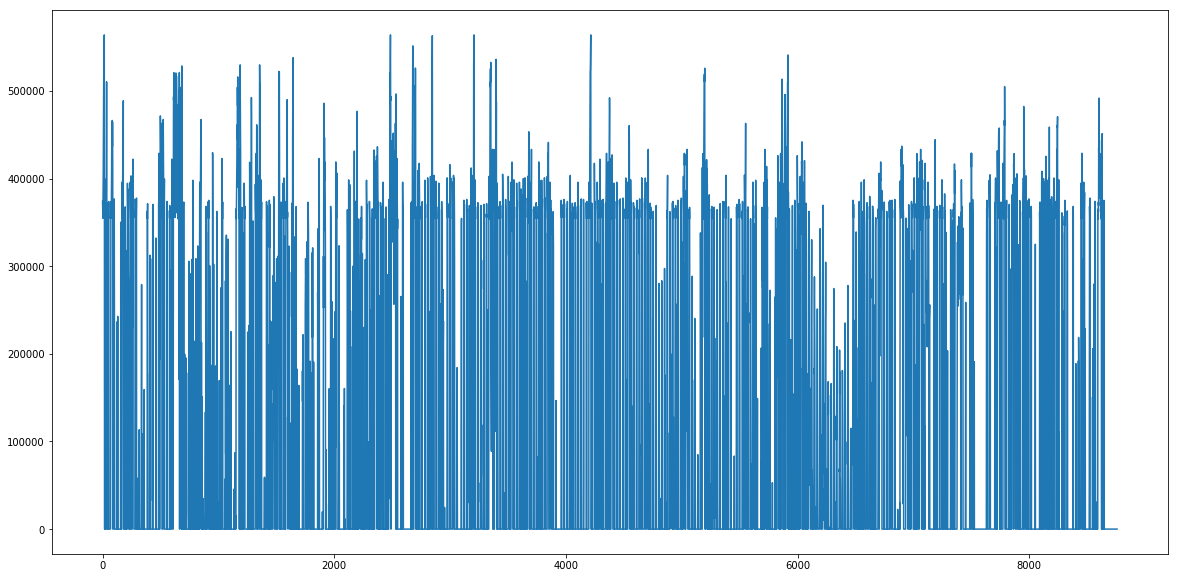

In [94]:
create_plot(H2_df)

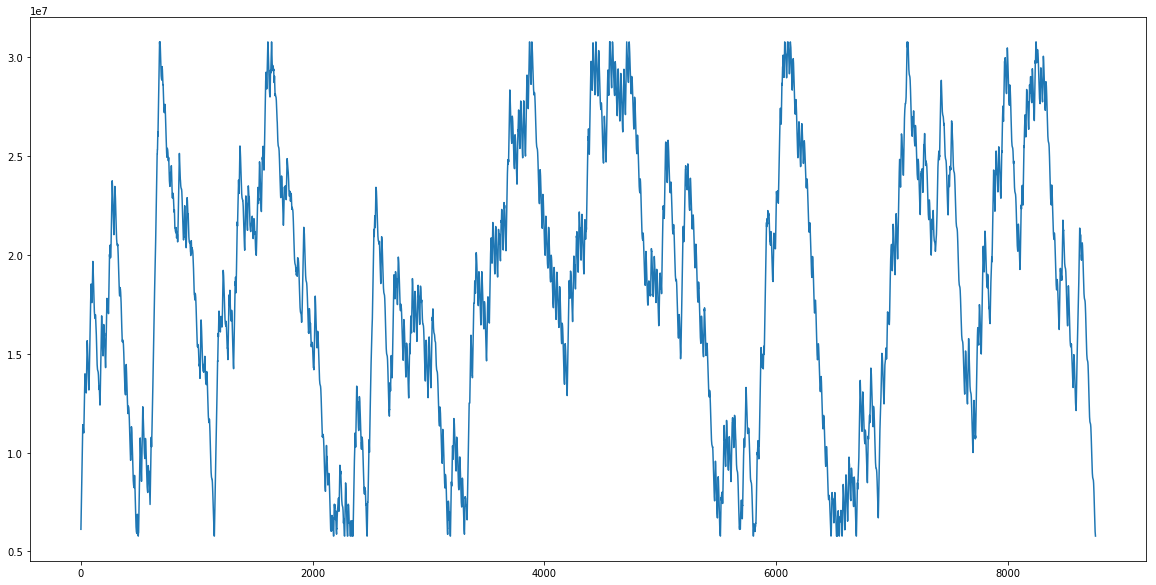

In [95]:
create_plot(I_H2_df)

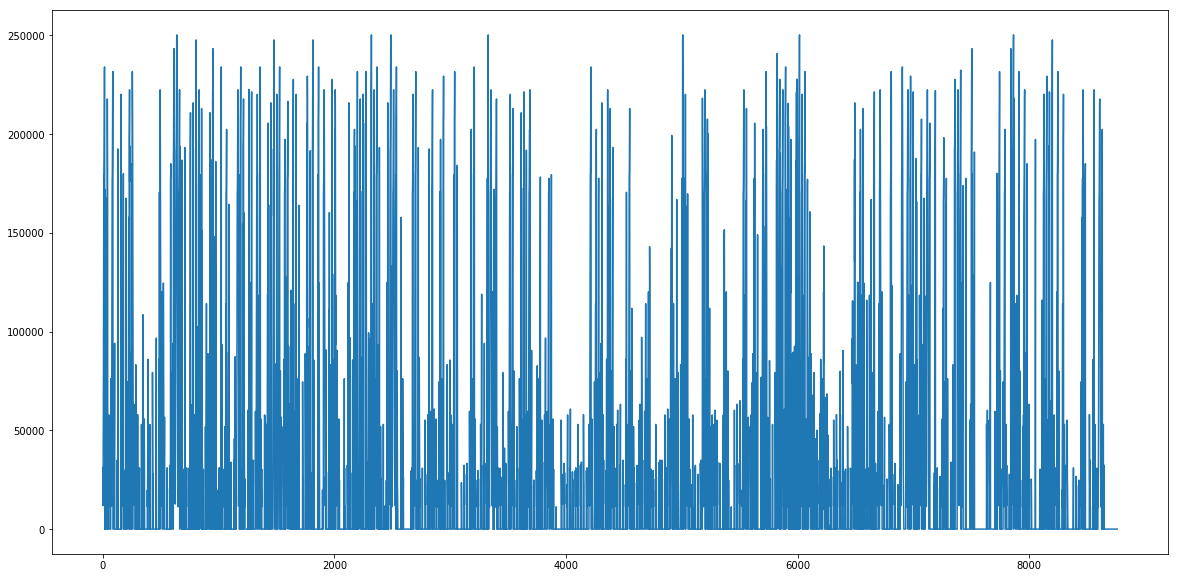

In [96]:
create_plot(H2_direct_df)

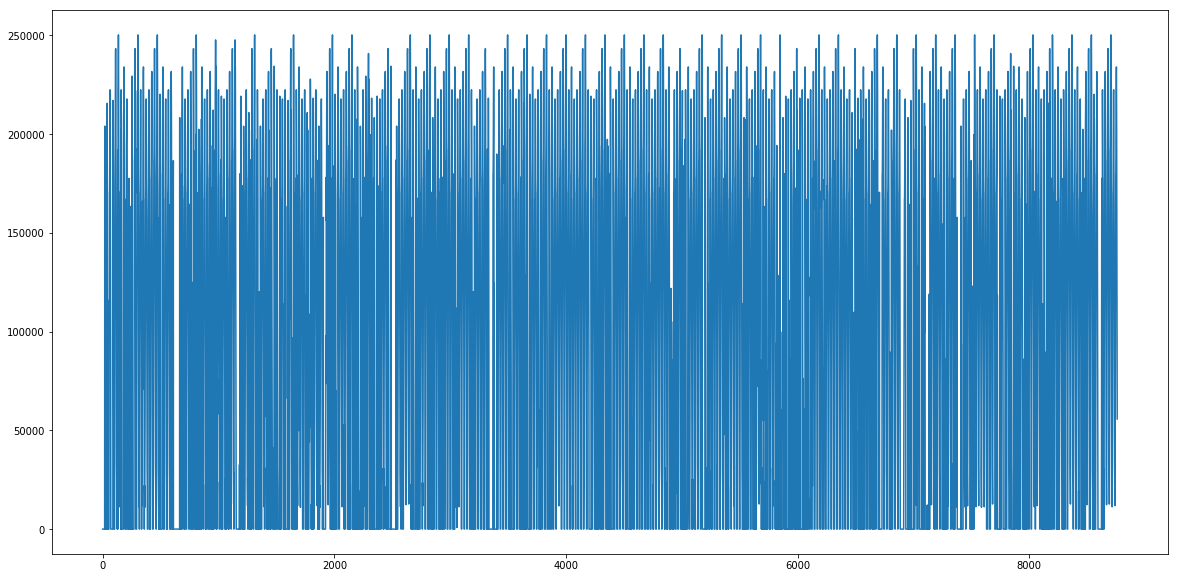

In [97]:
create_plot(H2_tank_out_df)

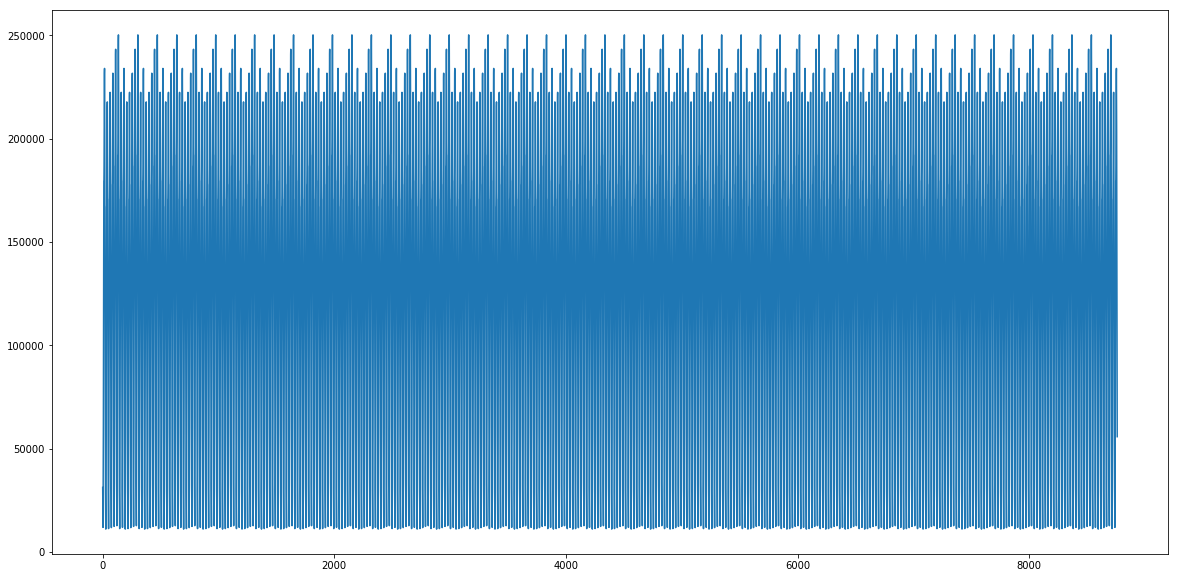

In [98]:
create_plot_list(mobility_demand)

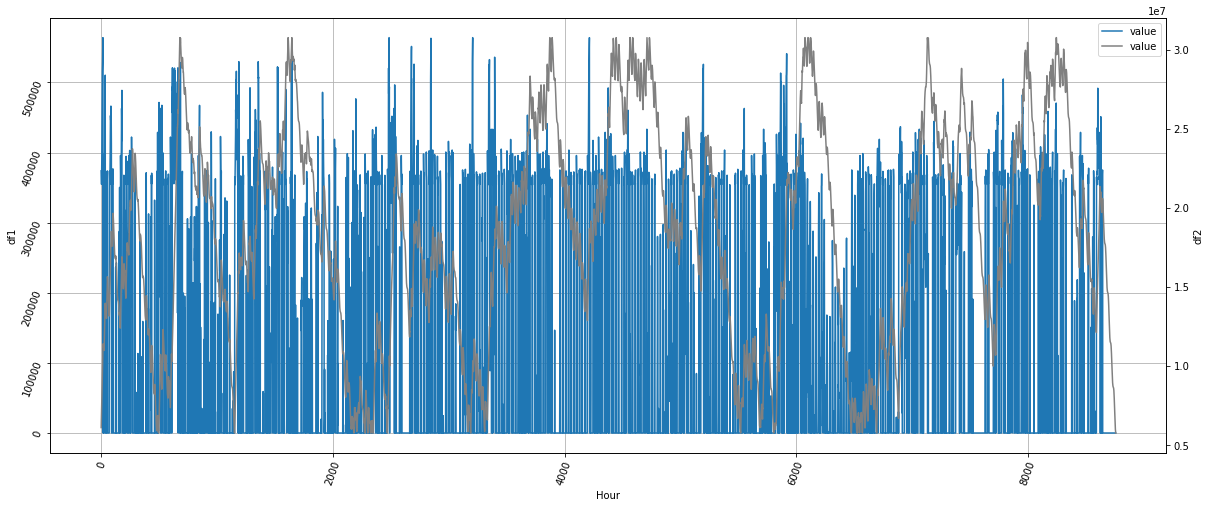

In [99]:
create_plot_two_lines(H2_3_df,I_H2_df)